## A-matrix method for measurement error mitigation

### Ritajit Majumdar
Research Scientist @ IBM Quantum

### Requirements

Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK 2.0 or later with visualization support (`pip install qiskit[visualization]`)
- Qiskit Aer 0.17 or later (`pip install qiskit-aer`)
- Qiskit Runtime 0.38 or later (`pip install qiskit-ibm-runtime`)

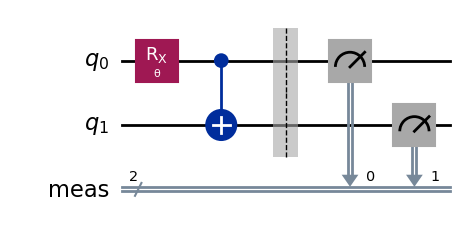

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rx(theta, 0)
qc.cx(0,1)
qc.measure_all()
qc.draw('mpl')

In [2]:
from qiskit.quantum_info import SparsePauliOp
observable_zz = SparsePauliOp('ZZ')
observable_zz

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])

#### Create a backend with measurement noise

In [3]:
from qiskit_aer.noise import NoiseModel, ReadoutError
noise_model = NoiseModel()

In [4]:
p0g1 = 0.02
p1g0 = 0.01

a_matrix = [[1-p1g0, p0g1], [p1g0, 1-p0g1]]
a_matrix

[[0.99, 0.02], [0.01, 0.98]]

In [5]:
from numpy import transpose
roerror = ReadoutError(transpose(a_matrix))
roerror

ReadoutError([[0.99 0.01]
 [0.02 0.98]])

In [6]:
from qiskit_aer import AerSimulator
noise_model.add_all_qubit_readout_error(roerror)
simulator = AerSimulator(noise_model=noise_model)
simulator

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure']>)

#### Obtain noisy counts and expvals

In [7]:
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(mode=simulator)
sampler.options.default_shots = 1000

In [8]:
from numpy import pi
pub = (qc, pi/3)

noisy_job = sampler.run([pub])
noisy_result = noisy_job.result()[0]
noisy_counts = noisy_result.data.meas.get_counts()
noisy_counts

{'00': 755, '11': 225, '01': 8, '10': 12}

In [9]:
from qiskit.result import sampled_expectation_value
noisy_expval = sampled_expectation_value(noisy_counts, observable_zz)
noisy_expval

0.96

#### Mitigation

In [10]:
noisy_prob = [noisy_counts['00']/1000,
             noisy_counts['01']/1000,
             noisy_counts['10']/1000,
             noisy_counts['11']/1000]
noisy_prob

[0.755, 0.008, 0.012, 0.225]

In [11]:
from numpy import kron
A_mat = kron(a_matrix, a_matrix)
A_mat

array([[9.801e-01, 1.980e-02, 1.980e-02, 4.000e-04],
       [9.900e-03, 9.702e-01, 2.000e-04, 1.960e-02],
       [9.900e-03, 2.000e-04, 9.702e-01, 1.960e-02],
       [1.000e-04, 9.800e-03, 9.800e-03, 9.604e-01]])

In [12]:
from numpy.linalg import inv
A_mat_inv = inv(A_mat)
A_mat_inv

array([[ 1.02072484e+00, -2.08311191e-02, -2.08311191e-02,
         4.25124880e-04],
       [-1.04155596e-02,  1.03114040e+00,  2.12562440e-04,
        -2.10436816e-02],
       [-1.04155596e-02,  2.12562440e-04,  1.03114040e+00,
        -2.10436816e-02],
       [ 1.06281220e-04, -1.05218408e-02, -1.05218408e-02,
         1.04166224e+00]])

In [13]:
from numpy import dot
mitigated_quasi = dot(A_mat_inv, noisy_prob)
mitigated_quasi

array([ 7.70326283e-01, -4.34690190e-03, -2.23190562e-04,  2.34243809e-01])

In [14]:
mitigated_counts = {'00': mitigated_quasi[0],
                   '01': mitigated_quasi[1],
                   '10': mitigated_quasi[2],
                   '11': mitigated_quasi[3],}
mitigated_counts

{'00': 0.7703262833457327,
 '01': -0.00434690190243384,
 '10': -0.00022319056222765404,
 '11': 0.23424380911892873}

In [15]:
mitigated_expval = sampled_expectation_value(mitigated_counts, observable_zz)
mitigated_expval

1.009140184929323

### But how do I know the A-matrix?

In [16]:
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
backend = FakeKolkataV2()

#### Calibration

In [17]:
qc_0 = QuantumCircuit(2)
qc_0.measure_all('mpl')

qc_1 = QuantumCircuit(2)
qc_1.x([0,1])
qc_1.measure_all('mpl')

In [18]:
from qiskit import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, initial_layout=[8,9])

In [19]:
isa_qcs = pm.run([qc_0, qc_1])

In [20]:
sampler = SamplerV2(mode=backend)
sampler.options.default_shots = 1000
job = sampler.run(isa_qcs)

In [21]:
result_0 = job.result()[0]
counts_0 = result_0.data.meas.get_counts()
counts_0

{'00': 985, '10': 10, '01': 5}

In [22]:
result_1 = job.result()[1]
counts_1 = result_1.data.meas.get_counts()
counts_1

{'11': 974, '01': 17, '10': 9}

First let us work out the A-matrix for qubit 0 (i.e. physical qubit 8)

In [23]:
from qiskit.result import marginal_counts
p00 = marginal_counts(counts_0, indices=[0])
p10 = marginal_counts(counts_1, indices=[0])

In [24]:
print(p00)
print(p10)

{'0': 995, '1': 5}
{'1': 991, '0': 9}


In [25]:
p1g0 = p00['1']/1000
p0g1 = p10['0']/1000

print(f'p1g0: {p1g0}')
print(f'p0g1: {p0g1}')

p1g0: 0.005
p0g1: 0.009


In [26]:
a_matrix_q0 = [[1-p1g0, p0g1], [p1g0, 1-p0g1]]
a_matrix_q0

[[0.995, 0.009], [0.005, 0.991]]

Now let us work out the A-matrix for qubit 1 (i.e. physical qubit 9)

In [27]:
p01 = marginal_counts(counts_0, indices=[1])
p11 = marginal_counts(counts_1, indices=[1])

In [28]:
print(p01)
print(p11)

{'0': 990, '1': 10}
{'1': 983, '0': 17}


In [29]:
p1g0 = p01['1']/1000
p0g1 = p11['0']/1000

print(f'p1g0: {p1g0}')
print(f'p0g1: {p0g1}')

p1g0: 0.01
p0g1: 0.017


In [30]:
a_matrix_q1 = [[1-p1g0, p0g1], [p1g0, 1-p0g1]]
a_matrix_q1

[[0.99, 0.017], [0.01, 0.983]]

In [31]:
A_mat = kron(a_matrix_q0, a_matrix_q1)
A_mat

array([[9.85050e-01, 1.69150e-02, 8.91000e-03, 1.53000e-04],
       [9.95000e-03, 9.78085e-01, 9.00000e-05, 8.84700e-03],
       [4.95000e-03, 8.50000e-05, 9.81090e-01, 1.68470e-02],
       [5.00000e-05, 4.91500e-03, 9.91000e-03, 9.74153e-01]])

In [32]:
A_mat_inv = inv(A_mat)
A_mat_inv

array([[ 1.01540060e+00, -1.75603360e-02, -9.22159983e-03,
         1.59478329e-04],
       [-1.03296094e-02,  1.02263133e+00,  9.38107816e-05,
        -9.28726738e-03],
       [-5.12311102e-03,  8.85990715e-05,  1.01949909e+00,
        -1.76312152e-02],
       [ 5.21171009e-05, -5.15959299e-03, -1.03713031e-02,
         1.02675900e+00]])

#### Let us run the same circuit on FakeKolkataV2 and perform the mitigation

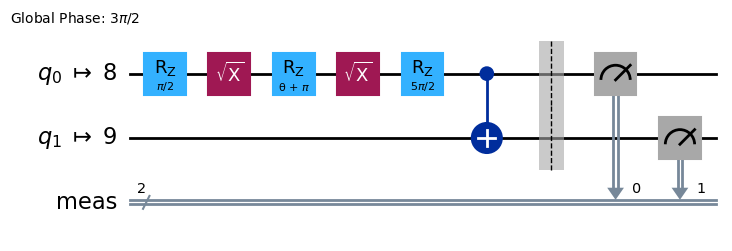

In [33]:
isa_qc = pm.run(qc)
isa_qc.draw('mpl', idle_wires=False)

In [34]:
pub = (isa_qc, pi/3)

noisy_job = sampler.run([pub])
noisy_result = noisy_job.result()[0]
noisy_counts = noisy_result.data.meas.get_counts()
noisy_counts

{'00': 742, '11': 239, '01': 11, '10': 8}

In [35]:
noisy_expval = sampled_expectation_value(noisy_counts, observable_zz)
noisy_expval

0.962

In [36]:
noisy_prob = [noisy_counts['00']/1000,
             noisy_counts['01']/1000,
             noisy_counts['10']/1000,
             noisy_counts['11']/1000]
noisy_prob

[0.742, 0.011, 0.008, 0.239]

In [37]:
mitigated_quasi = dot(A_mat_inv, noisy_prob)
mitigated_quasi

array([7.53198426e-01, 1.36546804e-03, 1.41758514e-04, 2.45294347e-01])

In [38]:
mitigated_counts = {'00': mitigated_quasi[0],
                   '01': mitigated_quasi[1],
                   '10': mitigated_quasi[2],
                   '11': mitigated_quasi[3],}
mitigated_counts

{'00': 0.7531984264804904,
 '01': 0.0013654680428360853,
 '10': 0.0001417585143707687,
 '11': 0.2452943469623027}

In [39]:
mitigated_expval = sampled_expectation_value(mitigated_counts, observable_zz)
mitigated_expval

0.9969855468855863

**Summary**: Note that a backend is susceptible to many other types of noise apart from measurement error. These other types of noise start dominating when the circuits start getting bigger. We simply mitigated the effect of measurement error here. There are other techniques, such as ZNE, PEC, PEA, for mitigating the effect of other types of noise, which, when applied together with measurement error mitigation, can often retrieve results very close to the ideal value.

**P.S.** Note that the A-matrix method is the simplest technique for error mitigation. There are other more advanced techniques, such as M3 and TREX, which are now in use for measurement error mitigation in IBM Quantum systems.